# Downscaling Temperature at 2m for the **Manhattan** area

**Variables:**
* Variable to be downscaled: Temperature at 2 meters (T2)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 3451.3 km²

In [7]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [8]:
!python --version

Python 3.8.18


# Retrieve files from server

In [9]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_test_data.nc')

# Calculating Spatial Coverage:

In [26]:
import xarray as xr
import numpy as np
from geopy.distance import geodesic

# Load the dataset
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')

# Extract latitude and longitude
lat = uwrf_train['latitude'].values  # Assuming 'latitude' is the name of the dimension
lon = uwrf_train['longitude'].values  # Assuming 'longitude' is the name of the dimension

# Compute the distance between two adjacent latitude points (in km)
lat_diff = np.abs(lat[1] - lat[0])  # Difference between two adjacent latitude points
lat_distance_km = lat_diff * 111  # 1 degree of latitude ~ 111 km

# Compute the distance between two adjacent longitude points (in km)
lon_diff = np.abs(lon[1] - lon[0])  # Difference between two adjacent longitude points
lon_distance_km = lon_diff * 111 * np.cos(np.radians(lat[0]))  # Adjust for latitude

# Calculate the area of one grid cell (in km²)
cell_area_km2 = lat_distance_km * lon_distance_km

# Calculate the total area covered by the dataset (in km²)
num_lat_cells = len(lat)
num_lon_cells = len(lon)
total_area_km2 = num_lat_cells * num_lon_cells * cell_area_km2

# Output the total area
print(f"Total area covered by the dataset: {total_area_km2} km²")

Total area covered by the dataset: 3451.2937839810534 km²


# Accessing specific variable from each dataset

In [10]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC

#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Normalization:

In [11]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)


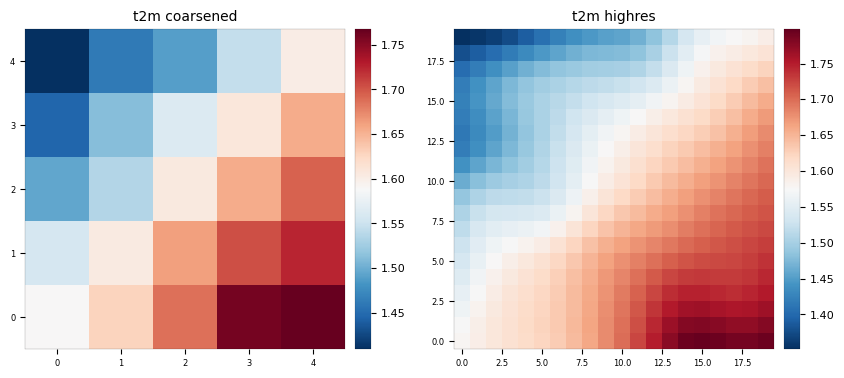

In [12]:
ecv.plot((x_train[0].values, y_train[0]), subplot_titles=('t2m coarsened', 't2m highres'))

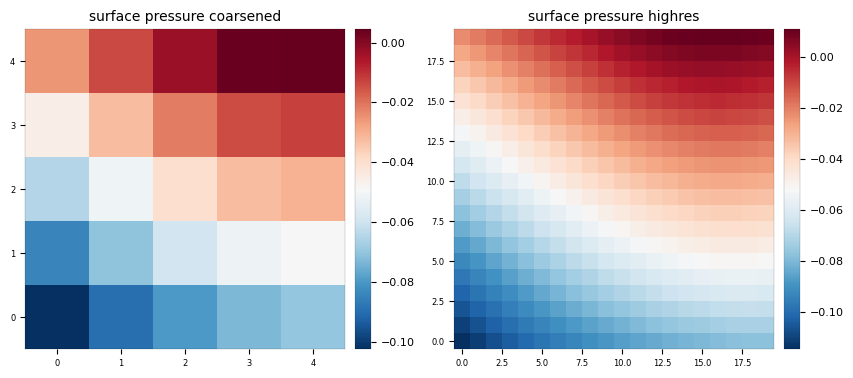

In [13]:
ecv.plot((x_z_train[0].values, y_z_train[0]), subplot_titles=('surface pressure coarsened', 'surface pressure highres'))

In [14]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

In [15]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 20, 20, 1) (812, 20, 20, 1) (812, 20, 20, 1)

PSFC hr data shape:
(1537, 20, 20, 1) (812, 20, 20, 1) (812, 20, 20, 1)

T2 lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)

PSFC lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)


HR array: (20, 20, 1), LR array (5, 5, 2)


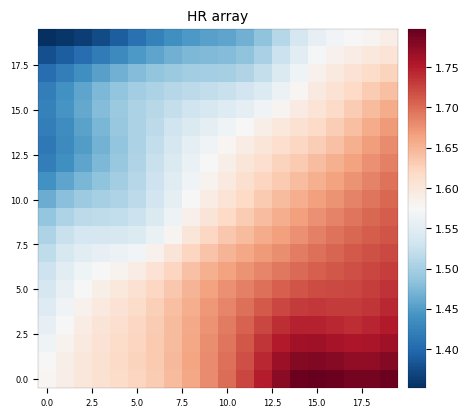

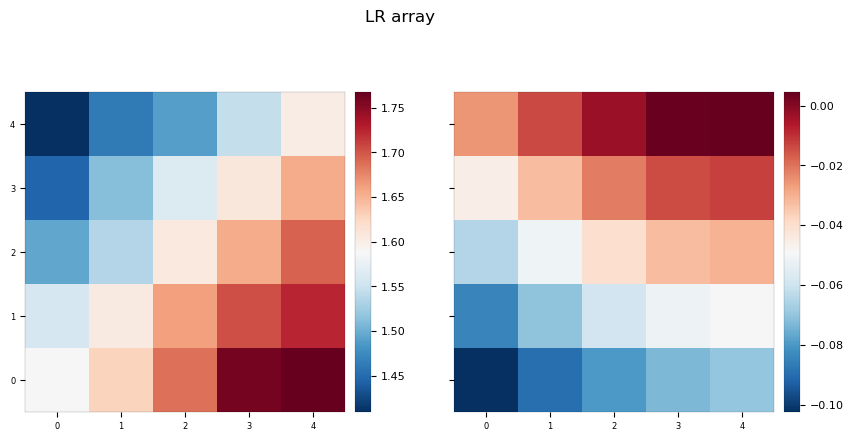

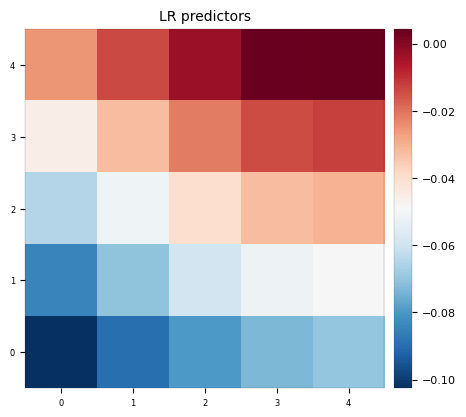

In [16]:
#Check for correct creation of the low-res version of uWRF
#This function is called before training begins. This is just an example to show what is going on:

_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

There are several types of backbones to try, so here we will implement each one and evaluate which performs best.

* resnet: MAE = 0.09434913098812103
* densenet: MAE = 0.04823455959558487 **best**
* convnet: MAE = 0.4711471498012543
* convnext: MAE = doesn't work

In [17]:
ARCH_PARAMS = dict(n_filters=20,
                   n_blocks=4,
                   normalization='bn',
                   dropout_rate=0.5,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='densenet',
    upsampling='spc', 
    data_train=y_train,
    data_val=y_val,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train],
    predictors_val=[y_z_val],
    predictors_test=[y_z_test],
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60,
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()


List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:19:18
--------------------------------------------------------------------------------
Model: "densenet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_1 (InputLayer)                        [(None, None, None, 2)]                      0              []                                           
                                                                                                                                                      
 conv2d (Conv2D)                             (None

In [18]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=[y_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:20:44
--------------------------------------------------------------------------------
14/14 [==============================] - 1s 16ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.640043
--------------------------------------------------------------------------------


In [19]:
pred1 = dds.Predictor(
    trainer, 
    x_test, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[x_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:20:44
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 15ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.198067
--------------------------------------------------------------------------------


# Compare training results with the ground truth data (uWRF)

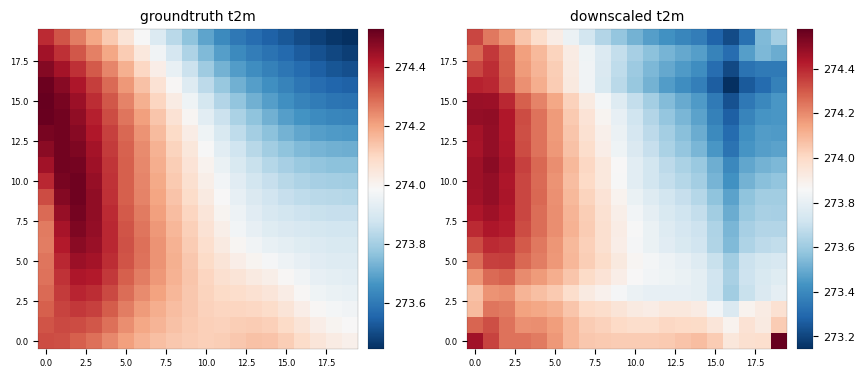

In [20]:
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_y_test[0].values, unscaled_y_pred[0]), subplot_titles=('groundtruth t2m', 'downscaled t2m'))

# Compare results with the original NAM data

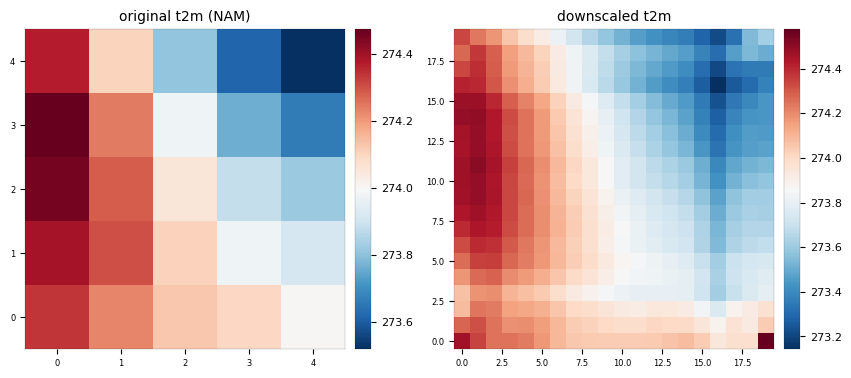

In [21]:
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
unscaled_x_train = T2_scaler_train.inverse_transform(x_train)
ecv.plot((unscaled_x_test[0].values, unscaled_x_pred[0]), subplot_titles=('original t2m (NAM)', 'downscaled t2m'))

# Compare results with ground truth data (uWRF)

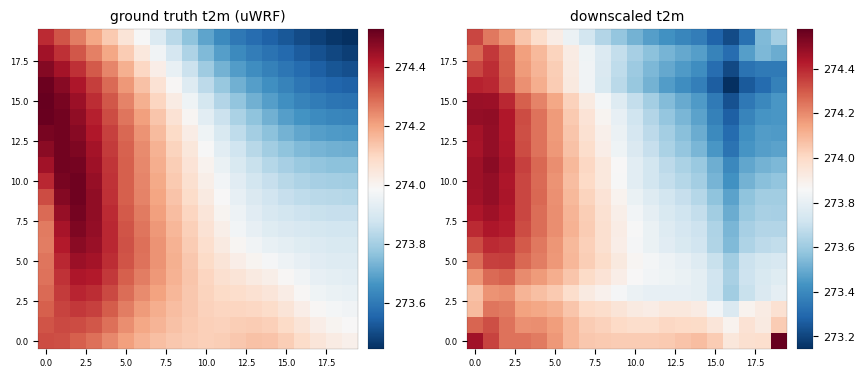

In [22]:
ecv.plot((unscaled_y_test[0].values, unscaled_x_pred[0]), subplot_titles=('ground truth t2m (uWRF)', 'downscaled t2m'))

# Loss

In [23]:
mae = dds.losses.mae(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")

MAE for training: 0.17761161923408508
MSE for training: 0.038911234587430954

MAE on NAM: 0.17761780321598053
MSE on NAM: 0.03891364485025406

MAE loss is not the same
MSE loss is not the same
MAE between predictions, to see if they're exactly the same:
MAE: 8.77380352903856e-06


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
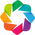

:DynamicMap   [time]
   :Image   [x,y]   (values)

In [24]:
ecv.plot(unscaled_y_test.values)

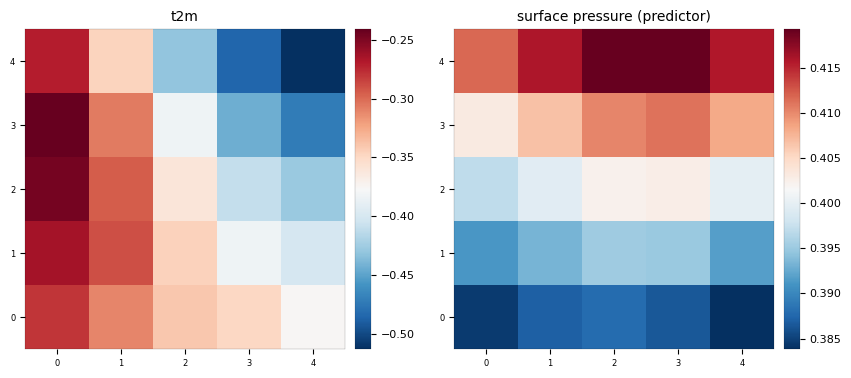

In [25]:
#predictors:

ind = 0
ecv.plot((coarsened_array[ind][:,:,0], coarsened_array[ind][:,:,1]), subplot_titles=('t2m', 'surface pressure (predictor)'),)